In [139]:
import pandas as pd
import matplotlib.pyplot as plt
import re

##### 1. 필요 라이브러리 및 파일 불러오기

In [74]:
file_path = './match_2018.csv'

# Import a CSV file and convert it to a pandas dataframe
try:
    matchData = pd.read_csv(file_path)
    message = "Dataframe has been successfully created."
except Exception as e:
    matchData = None
    message = f"Dataframe creation has been failed: {e}"

print(message)

Dataframe has been successfully created.


In [75]:
file_path = './hitter_2018.csv'

# Import a CSV file and convert it to a pandas dataframe
try:
    hitterData = pd.read_csv(file_path)
    message = "Dataframe has been successfully created."
except Exception as e:
    hitterData = None
    message = f"Dataframe creation has been failed: {e}"

print(message)

Dataframe has been successfully created.


In [76]:
file_path = './pitcher_2018.csv'

# Import a CSV file and convert it to a pandas dataframe
try:
    pitcherData = pd.read_csv(file_path)
    message = "Dataframe has been successfully created."
except Exception as e:
    pitcherData = None
    message = f"Dataframe creation has been failed: {e}"

print(message)

Dataframe has been successfully created.


In [77]:
print(matchData.shape)
print(hitterData.shape)
print(pitcherData.shape)

(721, 7)
(18224, 17)
(6258, 24)


##### 2. HAHA

In [78]:
def generate_matchID(match_date, home_team, away_team, year):
    team_mapping = {
        '롯데': 'LT',
        'SSG': 'SK',
        '한화': 'HH',
        '키움': 'WO',
        '삼성': 'SS',
        'NC': 'NC',
        'LG': 'LG',
        'KIA': 'HT',
        '두산': 'OB',
        'KT': 'KT'
    }

    home_team_id = team_mapping.get(home_team, 'XX')  # 홈팀이 없는 경우 'XX'를 사용
    away_team_id = team_mapping.get(away_team, 'XX')

    # match_date를 문자열로 변환하여 앞 8자리를 가져오고, home_team_id를 뒤에 2자리에 추가하고, 연도를 마지막 4자리에 추가
    match_id = match_date.strftime('%Y%m%d')[:8] + away_team_id + home_team_id + '0' + str(year)

    return match_id

# 예제 사용:
from datetime import datetime

match_date = datetime(2018, 4, 26)
home_team = '한화'
away_team = '키움'
year = 2018
match_id = generate_matchID(match_date, home_team, away_team, year)
print(match_id)  # 출력 예: '20180426LT2018'

20180426WOHH02018


In [79]:
print(matchData.columns)

Index(['Unnamed: 0', '월', '일', '원정', '홈', '원정점수', '홈점수'], dtype='object')


In [80]:
# 'Unnamed: 0' 열을 활용하여 matchID 생성 및 열 대체
matchData['matchID'] = matchData.apply(lambda row: generate_matchID(pd.Timestamp(2018, row['월'], row['일']), row['홈'], row['원정'], 2018), axis=1)

# 'Unnamed: 0' 열 제거
matchData.drop(columns=['Unnamed: 0'], inplace=True)

# 결과 확인
print(matchData)

      월   일  원정    홈  원정점수  홈점수            matchID
0     3  24  한화   키움     3    6  20180324HHWO02018
1     3  24  KT  KIA     5    4  20180324KTHT02018
2     3  24  LG   NC     2    4  20180324LGNC02018
3     3  24  롯데  SSG     5    6  20180324LTSK02018
4     3  24  삼성   두산     6    3  20180324SSOB02018
..   ..  ..  ..  ...   ...  ...                ...
716  10  13  LG  SSG     3    2  20181013LGSK02018
717  10  13  롯데  KIA     5    1  20181013LTHT02018
718  10  13  NC   한화     8   10  20181013NCHH02018
719  10  13  키움   삼성     5   12  20181013WOSS02018
720  10  14  두산   롯데     5    1  20181014OBLT02018

[721 rows x 7 columns]


In [81]:
print(matchData.columns)

Index(['월', '일', '원정', '홈', '원정점수', '홈점수', 'matchID'], dtype='object')


In [82]:
# 한화가 원정팀인 경우 또는 홈팀인 경우를 필터링하여 hhMatchData 생성
hhMatchData = matchData[(matchData['원정'] == '한화') | (matchData['홈'].str.contains('한화'))]

(144, 7)
      월   일  원정    홈  원정점수  홈점수            matchID
0     3  24  한화   키움     3    6  20180324HHWO02018
5     3  25  한화   키움     4    1  20180325HHWO02018
10    3  27  한화   NC     6    9  20180327HHNC02018
15    3  28  한화   NC     6    2  20180328HHNC02018
20    3  29  한화   NC     1    4  20180329HHNC02018
..   ..  ..  ..  ...   ...  ...                ...
694  10   4  롯데   한화     7    2  20181004LTHH02018
696  10   6  한화   롯데     5    8  20181006HHLT02018
703  10   9  한화   KT    10    6  20181009HHKT02018
708  10  10  한화  KIA     1    6  20181010HHHT02018
718  10  13  NC   한화     8   10  20181013NCHH02018

[144 rows x 7 columns]


##### 1. 경기별 선발투수 데이터 크롤링

In [149]:
# 선발투수 데이터를 담을 빈 리스트 선언
firstPitchers = []

# hhMatchData를 순회하면서 matchID를 가져와 pitcherData에서 해당 matchid를 가진 데이터 추출
for _, row in hhMatchData.iterrows():
    matchid = row['matchID']
    team_part = matchid[8:]
    away_team = team_part[:2]

    # 원정팀이 한화인 경우 '원정' 경기에서 첫 번째 선발투수 데이터 추출
    if away_team == 'HH': 
        hanwha_pitchers = pitcherData[(pitcherData['matchid'] == matchid) & (pitcherData['경기장'] == '원정')]
    # 홈팀이 한화인 경우 '홈' 경기에서 첫 번째 선발투수 데이터 추출
    else:
        hanwha_pitchers = pitcherData[(pitcherData['matchid'] == matchid) & (pitcherData['경기장'] == '홈')]

    # 첫 번째 선발투수 데이터가 있는 경우 리스트에 추가
    if not hanwha_pitchers.empty:
        firstPitchers.append(hanwha_pitchers.iloc[0])

# 결과 확인
print(firstPitchers[1])

Unnamed: 0                 4280
투수명                          휠러
이닝                            7
피안타                           4
실점                            1
자책                            1
4사구                           2
삼진                            7
피홈런                           1
타자                           26
타수                           24
투구수                         105
경기                          1.0
승리                          1.0
패전                          0.0
세이브                         0.0
평균자책                       1.29
연도                         2018
월                             3
일                            25
소속팀                          키움
상대팀                          한화
경기장                          원정
matchid       20180325HHWO02018
Name: 4280, dtype: object


In [205]:
# firstPitchers 리스트를 데이터프레임으로 변환
firstPitchers_df = pd.DataFrame(firstPitchers)

# 컬럼명 추가
firstPitchers_df.columns = ['idx', '투수명', '이닝', '피안타', '실점', '자책', '4사구', '삼진', '피홈런', '타자', '타수', '투구수', '경기', '승리', '패전', '세이브', '평균자책', '연도', '월', '일', '소속팀', '상대팀', '경기장', 'matchid']

# 결과 확인
# print(firstPitchers_df.columns)
# print(firstPitchers_df.shape)
# print()
print(firstPitchers_df)

       idx  투수명   이닝  피안타  실점  자책  4사구  삼진  피홈런  타자  ...   패전  세이브   평균자책  \
4232  4232   샘슨    4    8   6   5    4   8    1  25  ...  1.0  0.0  11.25   
4280  4280   휠러    7    4   1   1    2   7    1  26  ...  0.0  0.0   1.29   
4327  4327  윤규진  3 ⅓    4   6   3    4   4    1  19  ...  1.0  0.0   8.10   
4373  4373  배영수    6    3   2   2    2   2    0  22  ...  0.0  0.0   3.00   
4414  4414  김민우  1 ⅓    3   0   0    1   2    0   8  ...  0.0  0.0   0.00   
...    ...  ...  ...  ...  ..  ..  ...  ..  ...  ..  ...  ...  ...    ...   
2904  2904   헤일    5    7   4   2    3   8    2  26  ...  3.0  0.0   4.28   
2920  2920  김민우    4    5   4   4    2   3    2  19  ...  9.0  0.0   6.39   
2977  2977   샘슨    2    4   1   1    3   0    0  13  ...  8.0  0.0   4.63   
3018  3018   헤일  5 ⅓    6   3   3    3   5    0  23  ...  4.0  0.0   4.34   
3119  3119  김민우  0 ⅔    2   2   2    2   2    0   6  ...  9.0  0.0   6.52   

        연도   월   일  소속팀  상대팀  경기장            matchid  
4232  2018   3  24  

In [206]:
def parse_inning(inning_str):
    # 이닝 문자열을 공백으로 분할하여 정수 부분과 분수 부분을 분리합니다.
    parts = inning_str.split()

    # 정수 부분만 있는 경우 (예: "5")
    if len(parts) == 1:
        return float(parts[0])
    
    # 정수와 분수가 모두 있는 경우 (예: "2 ⅓")
    elif len(parts) == 2:
        whole_part = float(parts[0])  # 정수 부분
        fraction_part = parts[1]  # 분수 부분

        # 분수를 부동소수점 값으로 변환합니다.
        if fraction_part == '⅓':
            fraction_value = 0.3
        elif fraction_part == '⅔':
            fraction_value = 0.7
        else:
            # 지원되지 않는 분수 형태인 경우 오류를 발생시킵니다.
            raise ValueError(f"Unsupported fraction part: {fraction_part}")

        return whole_part + fraction_value

    else:
        # 잘못된 형식의 입력인 경우 오류를 발생시킵니다.
        raise ValueError(f"Invalid inning format: {inning_str}")

# 이닝 데이터 전처리 적용
firstPitchers_df['이닝'] = firstPitchers_df['이닝'].apply(parse_inning)
print(firstPitchers_df)

       idx  투수명   이닝  피안타  실점  자책  4사구  삼진  피홈런  타자  ...   패전  세이브   평균자책  \
4232  4232   샘슨  4.0    8   6   5    4   8    1  25  ...  1.0  0.0  11.25   
4280  4280   휠러  7.0    4   1   1    2   7    1  26  ...  0.0  0.0   1.29   
4327  4327  윤규진  3.3    4   6   3    4   4    1  19  ...  1.0  0.0   8.10   
4373  4373  배영수  6.0    3   2   2    2   2    0  22  ...  0.0  0.0   3.00   
4414  4414  김민우  1.3    3   0   0    1   2    0   8  ...  0.0  0.0   0.00   
...    ...  ...  ...  ...  ..  ..  ...  ..  ...  ..  ...  ...  ...    ...   
2904  2904   헤일  5.0    7   4   2    3   8    2  26  ...  3.0  0.0   4.28   
2920  2920  김민우  4.0    5   4   4    2   3    2  19  ...  9.0  0.0   6.39   
2977  2977   샘슨  2.0    4   1   1    3   0    0  13  ...  8.0  0.0   4.63   
3018  3018   헤일  5.3    6   3   3    3   5    0  23  ...  4.0  0.0   4.34   
3119  3119  김민우  0.7    2   2   2    2   2    0   6  ...  9.0  0.0   6.52   

        연도   월   일  소속팀  상대팀  경기장            matchid  
4232  2018   3  24  

In [209]:
# 데이터프레임의 인덱스를 0부터 시작하도록 재설정
firstPitchers_df = firstPitchers_df.reset_index(drop=True)

# 수정된 데이터프레임을 출력하여 확인
print(firstPitchers_df)

      idx  투수명   이닝  피안타  실점  자책  4사구  삼진  피홈런  타자  ...   패전  세이브   평균자책  \
0    4232   샘슨  4.0    8   6   5    4   8    1  25  ...  1.0  0.0  11.25   
1    4280   휠러  7.0    4   1   1    2   7    1  26  ...  0.0  0.0   1.29   
2    4327  윤규진  3.3    4   6   3    4   4    1  19  ...  1.0  0.0   8.10   
3    4373  배영수  6.0    3   2   2    2   2    0  22  ...  0.0  0.0   3.00   
4    4414  김민우  1.3    3   0   0    1   2    0   8  ...  0.0  0.0   0.00   
..    ...  ...  ...  ...  ..  ..  ...  ..  ...  ..  ...  ...  ...    ...   
139  2904   헤일  5.0    7   4   2    3   8    2  26  ...  3.0  0.0   4.28   
140  2920  김민우  4.0    5   4   4    2   3    2  19  ...  9.0  0.0   6.39   
141  2977   샘슨  2.0    4   1   1    3   0    0  13  ...  8.0  0.0   4.63   
142  3018   헤일  5.3    6   3   3    3   5    0  23  ...  4.0  0.0   4.34   
143  3119  김민우  0.7    2   2   2    2   2    0   6  ...  9.0  0.0   6.52   

       연도   월   일  소속팀  상대팀  경기장            matchid  
0    2018   3  24   키움   한화   원정 

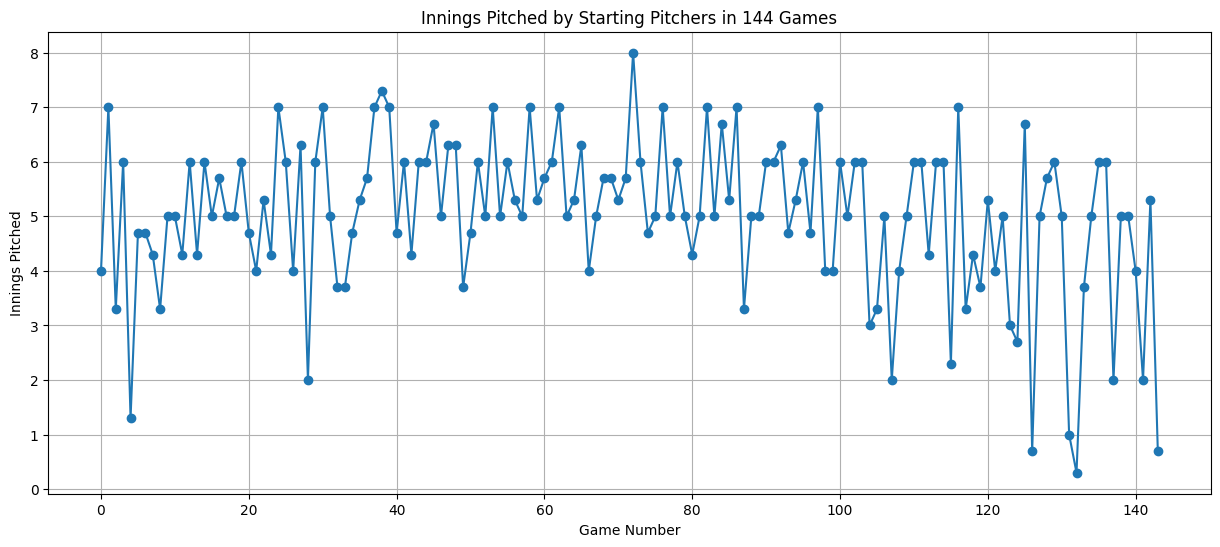

In [210]:
# Creating a simple line plot
plt.figure(figsize=(15, 6))
plt.plot(firstPitchers_df['이닝'], marker='o', linestyle='-')
plt.title('Innings Pitched by Starting Pitchers in 144 Games')
plt.xlabel('Game Number')
plt.ylabel('Innings Pitched')
plt.grid(True)
plt.show()